In [2]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
%matplotlib inline

import sklearn
import shap
from xgboost import XGBRegressor

from sklearn.linear_model import Lasso, Ridge
from sklearn.svm import SVR
import sklearn.gaussian_process as gp
from skopt.learning import ExtraTreesRegressor as opt_ETR
from skopt.learning import RandomForestRegressor as opt_RFR

from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, train_test_split

import pickle
import sys, os
import time
from scipy.stats import norm, expon
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


import warnings
warnings.filterwarnings('ignore')

import random
random.seed(1107)
np.random.seed(1107)

In [4]:
plt.rcParams['font.size'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.family'] = 'Hiragino sans'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['xtick.major.width'] = 1.0
plt.rcParams['ytick.major.width'] = 1.0
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = False
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 2
plt.rcParams["legend.markerscale"] = 2
plt.rcParams["legend.fancybox"] = False
plt.rcParams["legend.framealpha"] = 1
plt.rcParams["legend.edgecolor"] = 'black'

In [5]:
USAGE_DESC = ['AN', 'AW', 'atomic radius', 'electronegativity',
              'm. p.', 'b. p.', 'delta_fus H', 'density',
              'ionization energy', 'Surface energy']

desc_4 = ['electronegativity','delta_fus H','density','Surface energy']

In [6]:
def read_desc(std = False):
    desc = pd.read_csv('data/Descriptors_WGS.csv', encoding='shift-jis',
                       skiprows=[0], index_col="symbol")
    desc = desc.loc[:, ['AN', 'AW', 'atomic radius', 'electronegativity',
                        'm. p.', 'b. p.', 'delta_fus H', 'density',
                        'ionization energy', 'Surface energy']]
    desc.columns = USAGE_DESC
    if std:
        from sklearn.preprocessing import StandardScaler
        std = StandardScaler()
        desc = std.fit_transform(desc)
    desc = desc.fillna(desc.mean())
    return desc

def data_convert():
    data = pd.read_excel('data/WGS.xlsx', skiprows=8).drop(['Total # of Data', 'Reference', 'Data'], axis=1)
    print('# of Original Datapoints:', len(data))
    drop_support = ['ZEO', 'HAP', 'ACC', 'YSZ']
    idx = (data.loc[:, drop_support] == 0).all(axis=1)
    data = data[idx].drop(drop_support, axis=1)
    data.index = np.arange(len(data))
    print('# of Data after preprocessing:', len(data))

    desc = read_desc()

    support = pd.read_excel('data/support.xlsx')
    element = list(desc.index)
    data = pd.concat([pd.DataFrame(columns=element), data]).fillna(0.0)

    support_wt = np.array(100 - data.loc[:, element].sum(axis=1)
                          ).reshape(-1, 1)*np.array(data.loc[:, support.support])
    support_wt = support_wt / np.array(support.ave_MW).T
    data.loc[:, element] = data.loc[:, element] / desc.AW
    data.loc[:, support.key] += support_wt
    data.loc[:, element] = data.loc[:, element] / \
        np.array(data.loc[:, element].sum(axis=1)).reshape(-1, 1) * 100
    data = data.drop(support.support, axis=1)

    swed_names = []
    for i in range(4):
        for s in list(desc.columns):
            swed_names.append(f"{s} ({i + 1})")

    swed = pd.DataFrame(comp_times_base(data.loc[:, element], desc.T, sort=True)).iloc[:, :40]
    print(swed)
    print(np.array(swed_names).shape)
    swed.columns = swed_names

    data = pd.concat([data, swed], axis=1)
    data.to_csv('data/wgs.csv', index=None)
    return data, desc

def data_load(name):
    desc_names = []
    data = pd.read_csv('data/wgs.csv')
    idx = data.loc[:, 'Reaction Temperture (℃)'] <= 150
    data = data[idx]

    ELEMENT = data.loc[:, "Li":"Th"].columns
    SWED = data.loc[:, 'AN (1)':'Surface energy (4)'].columns
    EXPERIMENTAL = data.loc[:, "IWI":"F/W (mg.min/ml)"].columns

    target_col = "CO Conversion"
    CONVENTIONAL = list(ELEMENT) + list(EXPERIMENTAL)
    PROPOSE1 = list(ELEMENT) + list(SWED) + list(EXPERIMENTAL)
    PROPOSE2 = list(SWED) + list(EXPERIMENTAL)
    PROPOSE3 = list(PROPOSE2)

    for i in range(1,5):
        PROPOSE1.remove('AN ({})'.format(i))

    for i in range(1,5):
        PROPOSE2.remove('AN ({})'.format(i))

    for i in range(1,5):
        PROPOSE3.remove('AN ({})'.format(i))
        PROPOSE3.remove('AW ({})'.format(i))
        PROPOSE3.remove('atomic radius ({})'.format(i))
        PROPOSE3.remove('m. p. ({})'.format(i))
        PROPOSE3.remove('b. p. ({})'.format(i))
        PROPOSE3.remove('ionization energy ({})'.format(i))
        
    if name == "conv": # Conventional method
        feat = data.loc[:, CONVENTIONAL]
    elif name =="prop": # Proposed method (exploitative)
        feat = data.loc[:, PROPOSE1]
    elif name =="prop2": # Proposed method (explorative 9 desc.)
        feat = data.loc[:, PROPOSE2]
    elif name =="prop3": # Proposed method (explorative 4 desc.)
        feat = data.loc[:, PROPOSE3]
    target = data.loc[:, target_col]
    return feat, target

def get_columns(data, use_cols):
    element = list(data.loc[:, 'Li':'Th'].columns)
    preparation = list(data.loc[:, 'IWI': 'DP'].columns)
    condition = list(data.loc[:, 'Calcination Temperture (℃)':'F/W (mg.min/ml)'].columns)

    swed_names = []
    for i in range(4):
        for s in list(use_cols):
            swed_names.append(f"{s} ({i + 1})")
    cols = {}
    cols['element'] = element
    cols['preparation'] = preparation
    cols['condition'] = condition
    cols['use_cols'] = use_cols
    cols['swed'] = swed_names
    cols['conv'] = element + preparation + condition
    cols['prop1'] = element + preparation + condition + swed_names
    cols['prop2'] = preparation + condition + swed_names
    cols['target'] = 'CO Conversion'
    return cols

def data_loader(convert=False, desc_names=USAGE_DESC, temp=None):
    for s in desc_names:
        if s not in USAGE_DESC:
            print(f'{s} is not avaiable!!')
            print('Please use only in ', USAGE_DESC)
            return None

    if convert:
        data, desc = data_convert()
    else:
        data = pd.read_csv('data/wgs.csv')
        desc = read_desc()

    if temp is not None:
        idx = data.loc[:, 'Reaction Temperture (℃)'] <= temp
        data = data[idx]
        data.index = np.arange(len(data))

    cols = get_columns(data, desc_names)

    return data, desc, cols

def comp_times_base(comp, base, sort=False, times=True, attention=False):
    count = 0
    for key, rows in comp.iterrows():
        stack = np.vstack((rows, base))
        if times == True:
            time = np.array(base) * np.array(rows)
            stack = np.vstack((rows, time))

        if sort == True:
            stack = pd.DataFrame(stack).sort_values(
                [0], ascending=False, axis=1)

        stack = pd.DataFrame(stack).iloc[1:, :]
        stack = np.array(stack)

        if count == 0:
            if attention:
                res = np.sum(stack, axis=1)
            else:
                res = np.array(stack.T.flatten())

            count += 1
        else:
            if attention:
                res = np.vstack((res, np.sum(stack, axis=1)))
            else:
                res = np.vstack((res, np.array(stack.T.flatten())))

            count += 1
    return res


In [17]:
def grid_search(feat, target, use_model='ETR'):
    print(use_model)
    cvf = KFold(n_splits=10, shuffle=True, random_state=1107)
    if 'ETR' == use_model:
        cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs=1, random_state=1107),
                               param_grid={"n_estimators": [100, 250, 500, 1000, 1500]},
                               n_jobs=4,cv=5)
        error = crossvalid(feat, target, cvmodel, cvf)

        model = opt_ETR(n_estimators=cvmodel.best_params_['n_estimators'],
                        n_jobs=4, random_state=1107)

    if 'RFR' == use_model:
        cvmodel = GridSearchCV(RandomForestRegressor(n_jobs=1, random_state=1107),
                               param_grid={"n_estimators": [100, 250, 500, 1000, 1500]},
                               n_jobs=4,cv=5)
        error = crossvalid(feat, target, cvmodel, cvf)

        model = opt_RFR(n_estimators=cvmodel.best_params_['n_estimators'],
                        n_jobs=4, random_state=1107)

    return model, error

def crossvalid(xx, yy, model, cvf):
    err_trn = []
    err_tes = []
    r_2_tes = []
    r_2_trn = []
    for train_index, test_index in cvf.split(xx):
	    x_trn = pd.DataFrame(np.array(xx)[train_index], columns =xx.columns)
	    x_tes = pd.DataFrame(np.array(xx)[test_index], columns = xx.columns)
	    y_trn = np.array(yy)[train_index]
	    y_tes = np.array(yy)[test_index]
	    model.fit(x_trn,y_trn)
	    x_trn_pred = model.predict(x_trn)
	    x_tes_pred = model.predict(x_tes)
	    
	    err_tes.append(mean_squared_error(x_tes_pred, y_tes))
	    err_trn.append(mean_squared_error(x_trn_pred, y_trn))
	    r_2_tes.append(r2_score(y_tes, x_tes_pred))
	    r_2_trn.append(r2_score(y_trn, x_trn_pred))
    v_tes = np.sqrt(np.array(err_tes))
    v_trn = np.sqrt(np.array(err_trn))
    print ("RMSE %1.3f (sd: %1.3f, min:%1.3f, max:%1.3f, det:%1.3f) ... train" % (v_trn.mean(), v_trn.std(),v_trn.min(), v_trn.max(),np.array(r_2_trn).mean()))
    print ("RMSE %1.3f (sd: %1.3f, min:%1.3f, max:%1.3f, det:%1.3f) ... test" % (v_tes.mean(), v_tes.std(), v_tes.min(), v_tes.max(), np.array(r_2_tes).mean()))
    ret = {}
    ret['trn_mean'] = v_trn.mean()
    ret['trn_std'] = v_trn.std()
    ret['trn_r2'] = np.array(r_2_trn).mean()
    ret['tes_mean'] = v_tes.mean()
    ret['tes_std'] = v_tes.std()
    ret['tes_r2'] = np.array(r_2_tes).mean()
    return ret

def one_shot_plot(feat, target, model, xylim=[0, 100],  random_state=1107, save=False):
    plt.figure()
    plt.subplot().set_aspect('equal')
    x_train, x_test, y_train, y_test = train_test_split(feat, target, test_size=0.1, random_state=random_state)
    model.fit(x_train, y_train)
    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)
    plt.plot(y_test, y_test_pred, 'o', c='red', markersize=3, alpha=0.4, label='test')
    plt.plot(y_train, y_train_pred, 'o', c='blue', markersize=3, alpha=0.4, label='train')

    plt.plot([-100, 200], [-100, 200], c='0', ls='-', lw=1.0)
    plt.xlim(xylim)
    plt.ylim(xylim)
    plt.xlabel("Experimental {} (%)".format(target.name))
    plt.ylabel("Predicted {} (%)".format(target.name))

    if save is not False:
	    plt.savefig(save + 'one_shot_plot.png', dpi=1200, bbox_inches='tight')

def plot_importance(model, labels, topk):
    plt.figure(figsize =(6,6))
    importances = model.feature_importances_
    indices = np.argsort(importances)
    topk_idx = indices[-topk:]
    plt.barh(range(len(topk_idx)), importances[topk_idx], color = 'blue', align = 'center')
    plt.yticks(range(len(topk_idx)), labels[topk_idx])
    plt.ylim([-1, len(topk_idx)])
    plt.xlabel("Feature Importance")

def shap_importance(model, feat, target, save=False):
    explainer = shap.TreeExplainer(model=model)
    shap_values = explainer.shap_values(feat)

    shap.summary_plot(shap_values, feat, show=False)
    if save is not False:
	    plt.savefig(save + 'shap.png', dpi=1200, bbox_inches='tight')

In [9]:
def smac(model, init_x, init_y, roen_func, desc, cols, data, random_state = 1107):
    """
    The main Program of SMAC
    """
    model.fit(np.array(init_x.loc[:, cols['prop2']]), np.array(init_y))
    print(model)
    mu, sigma =  posterior(init_x.loc[:, cols['prop2']] , init_x.loc[:, cols['prop2']], init_y, model)
    ei =  EI(mu, sigma, init_y.max())
    ei = pd.Series(ei, index = init_x.index, name = 'ei')
    make_nei = pd.Series(True, index=init_x.index, name='make_nei')
    next_x = pd.concat([init_x, ei, make_nei], axis = 1)
    while next_x['make_nei'].sum() != 0:
        next_x = roen_func(next_x, init_y, model, desc, cols, data)
        print(next_x['make_nei'].sum())
    return next_x

def opt_function(x, y ,model, desc, cols, data, random_state =1107):
    """
    A function that searches the neighborhood four times
    for each experimental point and returns the composition
    and experimental condition with the highest EI.
    """
    xx = x.iloc[:,:-2]
    neighbor = pd.DataFrame(index = x.columns)
    for key, row in xx.iterrows():
        nei_cand = []
        #print('ind={0}'.format(key))
        if x.loc[key, 'make_nei'] == True:

            for _ in range(30):
                row_ch = row.copy() 
                row_ch = SWED_change(row_ch, desc, cols, data)
                nei_cand.append(row_ch)
                
            for _ in range(30):
                row_ch = row.copy()
                row_ch = experiment_change(row_ch, cols, data)
                nei_cand.append(row_ch)
                
            for _ in range(30):
                row_ch = row.copy()
                row_ch = SWED_change(row_ch, desc, cols, data)
                row_ch = experiment_change(row_ch, cols, data)
                nei_cand.append(row_ch)
                   
            nei_cand = pd.DataFrame(nei_cand, index =np.arange(len(nei_cand))).fillna(0)
            swed = comp_times_base(nei_cand.loc[:,cols['element']],
                                   desc.loc[cols['element']].T,sort=True,times=True)
            swed = pd.DataFrame(swed).iloc[:, :len(cols['swed'])].fillna(0)
            nei_cand.loc[:, cols['swed']] = np.array(swed)
                        
            mu, sigma = model.predict(np.array(nei_cand.loc[:, cols['prop2']]), return_std=True)
            ind = y.values.argmax()
            cur_max = y.iloc[ind]
            ei = EI(mu, sigma, cur_max)
            ind = np.argmax(ei)
            cand = nei_cand.iloc[ind].copy()
            cand['ei'] = ei[ind]
            if x.loc[key, 'ei'] < cand['ei']:
                cand['make_nei'] = True
                neighbor = pd.concat([neighbor, cand], axis = 1)
            else:
                x.loc[key, 'make_nei'] = False
                neighbor = pd.concat([neighbor, x.loc[key,:]], axis = 1)
                
        else:
            neighbor = pd.concat([neighbor, x.loc[key,:]], axis = 1)
                                                    
    print('-----------')
    
    neighbor = neighbor.T
    neighbor.index = x.index
    return neighbor


def SWED_change(row_ch, desc, cols, data):
    row_ch[cols['element']] = 0

    for i in range(0, 3):
        # Save the data of the i-1 th process.
        row_sub = row_ch
        x_ch =data

        # Local search for the addtional descriptor associated with
        # the change_f-th element from the largest one.
        change_col= []
        for s in cols['use_cols']:
            change_col.append(f'{s} ({i + 1})')
        a = row_ch[change_col] - x_ch[change_col].min()
        b = x_ch[change_col].max() - x_ch[change_col].min()
        v = a/b

        v = np.minimum(v, 1.0)
        v = np.maximum(v, 0.0)
        p = np.array([-1])
        count = 0
        while (p <0).any() | (p>1).any():
            p = random.normalvariate(v, 0.05)
            count += 1
            if (count % 1000) == 0:
                p = v
                break

        p = p * b + x_ch[change_col].min()
        row_ch[change_col] = p
        p = np.array(p)
        
        # alpha = x1_x0/x1_2
        # Position of the axes of a quadratic function
        alpha = desc.loc[:,cols['use_cols']].apply(lambda u: np.dot(u, p)/np.dot(u, u), axis = 1)
        # Return the name of the element with the smallest ε value
        epsilon = desc.loc[:,cols['use_cols']].mul(alpha, axis=0).apply(lambda u: np.dot(u-p, u-p), axis=1).sort_values().index


        for i in range(0, len(epsilon)):
            # Convert to an element with an axis less than 100
            # and a non-zero composition element.
            if (alpha[epsilon[i]] < 100) & (row_ch[epsilon[i]] == 0):
                row_ch[epsilon[i]] = alpha[epsilon[i]]
                break

        # Exit the process when the total composition exceeds 100.         
        if row_ch[cols['element']].sum() >= 100:
            break
    
    if row_sub[cols['element']].sum() == 0:
        print('enconunter divides zero')

    # Select a composition closer to 100 and normalize it.
    if  abs(100 -row_ch[cols['element']].sum()) > abs(100-row_sub[cols['element']].sum()):
        row_ch[cols['element']] =  (row_sub[cols['element']] * 100) / row_sub[cols['element']].sum()

    else:
        row_ch[cols['element']] =  (row_ch[cols['element']] * 100) / row_ch[cols['element']].sum()
    
    return row_ch

def experiment_change(row_ch, cols, data):
    x_ch = data

    change_f = random.choice(cols['condition'] + cols['preparation'])
    
    if change_f in cols['condition']:
        a = np.array(row_ch[change_f]) - x_ch[change_f].min()
        b = x_ch[change_f].max() - x_ch[change_f].min()
        if b != 0:
            v = a / b
            p = -1
            while (p < 0) | (p > 1):
                p = random.normalvariate(v, 0.05)

            p = p * b + x_ch[change_f].min()
            row_ch[change_f] = p

    elif change_f in cols['preparation']:
        row_ch[change_f] = 1
        ind = set(cols['preparation']) - {change_f}
        row_ch[ind] = 0
        
    return row_ch

def posterior(x, p_x, p_y, model):
    """
    Functions for calculating μ and σ used in EI calculation.
    """
    if len(p_x.shape) == 1:
        model.fit(p_x.reshape(-1, 1), p_y)
        mu, sigma = model.predict(x.reshape(-1, 1), return_std = True)
    else:
        model.fit(p_x, p_y)
        mu, sigma = model.predict(x, return_std = True)
    ind = np.where(sigma == 0)
    sigma[ind] = 1e-5
    return mu, sigma

def EI(mu, sigma, cur_max):
    """
    Function to calculate EI
    """
    Z = (mu - cur_max)/ sigma
    ei = (mu - cur_max) * norm.cdf(Z) + sigma*norm.pdf(Z)
    return ei

In [23]:
def rand_search(ninit, x, y, random_state = 1107):
    random.seed(random_state)
    ninit = ninit # number of first point
    niter = len(x) # number of iteration
    true_max = np.max(y)
    order = list(range(len(x)))
    random.shuffle(order)

    y_list = []
    z_list = []
    for i in range(ninit):
        ridx = order[i]
        y_list.append(y.iloc[ridx])
        
    cur_max = np.array(y_list).max()
    for j in range(100):
        ridx = order[j + ninit]
        y_list.append(y.iloc[ridx])
        yp = np.array(y_list)
        cur_max = np.max(yp)
        z_list.append(cur_max)
        
        if cur_max >= true_max:
            print('max found', j)
            
        print('iter:{0}, current_max:{1}'.format(j,cur_max))
     
    return z_list

def bo(ninit, model, x, y, random_state = 1107):
    random.seed(random_state)
    ninit = ninit # number of first point
    niter = len(x) # number of iteration
    true_max = np.max(y)
    order = list(range(len(x)))
    random.shuffle(order)

    x_list = []
    y_list = []
    z_list = []
    used = set()
    
    for i in range(ninit):
        ridx = order[i]
        x_list.append(x.iloc[ridx, :])
        y_list.append(y.iloc[ridx])
        used.add(ridx)

    for j in range(100):
        xp = np.array(x_list)
        yp = np.array(y_list)
        cur_max = np.max(yp)
        # fit surrogate model
        model.fit(xp, yp)
        _mu, sigma = posterior(x, x, y)
        mu = _mu.reshape(-1)
        ind = np.where(sigma == 0.)
        sigma[ind] = 1e-5
        # compute EI
        Z = (mu - cur_max) / sigma
        ei = (mu - cur_max) * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] == 0.0
        idlist = np.argsort(ei)[::-1]
        p = 0
        max_idx = idlist[p]
        while max_idx in used:
            p += 1
            max_idx = idlist[p]
        
        used.add(max_idx)
        x_list.append(x.iloc[max_idx, :])
        y_list.append(y.iloc[max_idx])
        z_list.append(cur_max)
            
        print('iter:{0}, current_max:{1}'.format(j,cur_max))
        
    return x_list, y_list, z_list

In [10]:
data, desc, cols = data_loader(convert = True, temp=150,
desc_names = ['electronegativity','delta_fus H','density','Surface energy'])

data.to_csv('data/wgs_below_150.csv')

# of Original Datapoints: 4360
# of Data after preprocessing: 4190
               0             1           2           3              4   \
0     5748.961685  13888.301990  183.372054  111.014433  105860.191020   
1     5646.512874  13640.806859  180.104290  109.036111  103973.719813   
2     5543.564800  13392.105612  176.820601  107.048148  102078.055280   
3     5748.961685  13888.301990  183.372054  111.014433  105860.191020   
4     5646.512874  13640.806859  180.104290  109.036111  103973.719813   
...           ...           ...         ...         ...            ...   
4185  1281.111592   2658.947109  116.285514  158.660743   91990.710583   
4186  1281.111592   2658.947109  116.285514  158.660743   91990.710583   
4187  1281.111592   2658.947109  116.285514  158.660743   91990.710583   
4188  1281.111592   2658.947109  116.285514  158.660743   91990.710583   
4189  1281.111592   2658.947109  116.285514  158.660743   91990.710583   

                 5            6           7 

In [12]:
%%time
print('ETR')
MODEL_TYPES = ['conv', 'prop2', 'prop3']

cvf = KFold(n_splits=10, shuffle=True, random_state=1107)
#cvf = ShuffleSplit(n_splits = 100, random_state = 1107, test_size = 0.2)

print('conv')
feat, target = data_load('conv')
cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs = -1, random_state = 1107),
                           param_grid = {'n_estimators':[100, 250, 500, 1000, 1500]},
                           n_jobs = -1)
crossvalid(feat, target, cvmodel, cvf)
print(cvmodel.best_params_)

print('prop2')
feat, target = data_load('prop2')
cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs = -1, random_state = 1107),
                           param_grid = {'n_estimators':[100, 250, 500, 1000, 1500]},
                           n_jobs = -1)
crossvalid(feat, target, cvmodel, cvf)
print(cvmodel.best_params_)

print('prop3')
feat, target = data_load('prop3')
cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs = -1, random_state = 1107),
                           param_grid = {'n_estimators':[100, 250, 500, 1000, 1500]},
                           n_jobs = -1)
crossvalid(feat, target, cvmodel, cvf)
print(cvmodel.best_params_)

ETR
conv
RMSE 1.691 (sd: 0.217, min:1.061, max:1.816, det:0.994) ... train
RMSE 10.411 (sd: 5.565, min:3.971, max:25.403, det:0.679) ... test
{'n_estimators': 500}
prop2
RMSE 1.691 (sd: 0.217, min:1.061, max:1.816, det:0.994) ... train
RMSE 9.431 (sd: 2.592, min:5.003, max:13.792, det:0.722) ... test
{'n_estimators': 1000}
prop3
RMSE 1.691 (sd: 0.217, min:1.061, max:1.816, det:0.994) ... train
RMSE 9.638 (sd: 2.822, min:4.582, max:14.757, det:0.708) ... test
{'n_estimators': 1500}
CPU times: user 29.6 s, sys: 11.8 s, total: 41.4 s
Wall time: 3min 17s


In [13]:
%%time
data, desc, cols = data_loader(convert = False, temp=150,
                               desc_names = ['electronegativity','delta_fus H','density','Surface energy'])
                               
model, error = grid_search(data.loc[:, cols['prop2']], data.loc[:, cols['target']], use_model='ETR')

ETR
RMSE 1.691 (sd: 0.217, min:1.061, max:1.816, det:0.994) ... train
RMSE 9.529 (sd: 2.679, min:4.866, max:14.502, det:0.719) ... test
CPU times: user 6.45 s, sys: 254 ms, total: 6.71 s
Wall time: 1min 3s


In [ ]:
%%time
cand, mu, sigma = smac(model, data.loc[:, cols['prop1']], data.loc[:, cols['target']], opt_function, desc, cols, data, random_state = 1107)
cand.to_csv("out/ETR/cand_ETR_4desc_prop2.csv")

In [ ]:
cand = pd.read_csv("out/ETR/cand_ETR_4desc_prop2.csv")
cand = cand.dropna()

from sklearn.cluster import KMeans

desc = read_desc()
element = list(desc.index)
feat = data.loc[:, cols['prop2']]
target = data.loc[:, cols['target']]

model = opt_ETR(n_estimators = 1000, n_jobs = 4)
k = KMeans(n_clusters=30, random_state = 1107)
cluster = k.fit_predict(cand.iloc[:,:-5])
cluster = pd.Series(cluster, index=cand.index, name='cluster')
cand = pd.concat([cand, cluster], axis=1)
model.fit(feat, target)
mean = model.predict(cand.loc[:,cols['prop2']])
mean = pd.Series(mean, index = cand.index, name = 'mean')
mu, sd = model.predict(cand.loc[:, cols['prop2']], return_std=True)
sd = pd.Series(sd, index = cand.index, name = 'sd') 
mean_np = np.array(mean)
sd_np = np.array(sd)
CI95_up, CI95_low = np.array(mean_np+(1.96*sd_np)).reshape(-1,1), np.array(mean_np-(1.96*sd_np)).reshape(-1,1)
CI95 = np.hstack([CI95_up, CI95_low])
CI95 = pd.DataFrame(CI95, index=cand.index, columns=['CI95_up', 'CI95_low'])
cand = pd.concat([cand, mean, sd, CI95], axis = 1)
#choose point which has most better ei value in each cluster
clus_high = cand.sort_values(by=['cluster','ei']).drop_duplicates(subset=['cluster'],keep='last')
clus_high = clus_high.sort_values(by='ei', ascending=False)
clus_high.to_csv("out/ETR/clus_high_ETR_4desc.csv")

catalysts = []
for key,row in clus_high.loc [:,element].iterrows():
    temp = [str(i)+':'+str(round(v,1)) for i,v in row[row>0].sort_values(ascending=False).iteritems()]
    catalysts.append(temp)
    
catalysts = [' '.join(x) for x in catalysts]

w = 0.4
topcatal = clus_high.iloc[:20]
x = np.arange(topcatal.shape[0])
pred_y = list(clus_high['mean'])
    
                
extra = []
for y in x:
    extra.append(y)
    
ytick = []
for n in range(20):
    ytick.append(catalysts[n])
    
plt.figure(figsize=(6,6), dpi=1200)
plt.barh(x,topcatal['ei'][::-1],label='EI', color = 'blue')
for n,i in enumerate(x[::-1]):
    plt.text(clus_high['ei'].iloc[n],i-0.4,str(round(clus_high['ei'].iloc[n],2)),fontsize=12)

clus_high.index = np.arange(len(clus_high))
EI = clus_high['ei']
temp = clus_high.loc[:, cols['condition']]
CI = clus_high.loc[:, ['mean', 'sd', 'CI95_up', 'CI95_low']]
prep_list = pd.Series(index = np.arange(len(clus_high)))

for s in cols['preparation']:
    idx = clus_high.loc[:,s] > 0
    prep_list[idx] = s
prep_list = prep_list.fillna('n.a.')
temp = pd.concat([pd.DataFrame(prep_list), temp, EI, CI], axis = 1)
temp.index = catalysts

plt.xlim([0, 1.2])
plt.yticks(x[::-1],ytick)
plt.xlabel('Expected improvement value')
#temp =clus_high.loc[:,"Temperature, K":"ei"]
#temp.index = hogege
temp.to_csv("out/ETR/table_ETR_4desc_prop2.csv")
plt.savefig('out/ETR/EI_propose_ETR_4desc_prop2.png', dpi=1200, bbox_inches = 'tight')

In [ ]:
(cand.loc[:,element] >0).sum().to_csv('out/ETR/cand_elem_count_ETR_4desc.csv', header = None)
cand_elem_num = (cand.loc[:,element] >0).sum()
idx = (cand.loc[:,element] >0).sum() > 0
cand_elem_num = cand_elem_num[idx]
cand_elem_num.to_csv('out/ETR/cand_elem_num_ETR_4desc.csv', header = None)
!python ptable_trends.py out/ETR/cand_elem_num_ETR_4desc.csv

conv
RMSE 1.691 (sd: 0.217, min:1.061, max:1.816, det:0.994) ... train
RMSE 10.411 (sd: 5.565, min:3.971, max:25.403, det:0.679) ... test
prop2
RMSE 1.691 (sd: 0.217, min:1.061, max:1.816, det:0.994) ... train
RMSE 9.431 (sd: 2.592, min:5.003, max:13.792, det:0.722) ... test
prop3
RMSE 1.691 (sd: 0.217, min:1.061, max:1.816, det:0.994) ... train
RMSE 9.638 (sd: 2.822, min:4.582, max:14.757, det:0.708) ... test
CPU times: user 30.7 s, sys: 1.62 s, total: 32.3 s
Wall time: 3min 22s


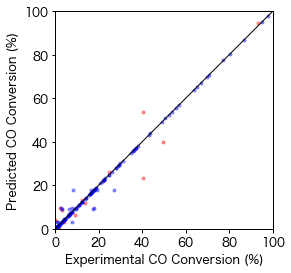

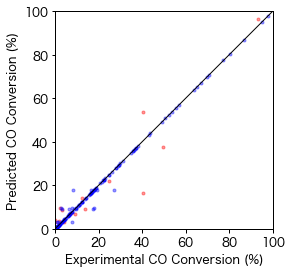

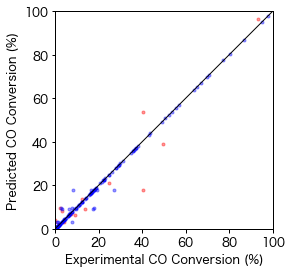

In [14]:
%%time
MODEL_TYPES = ['conv', 'prop2', 'prop3']

os.makedirs('out/ETR', exist_ok=True)
cvf = KFold(n_splits=10, shuffle=True, random_state=1107)
for model_type in MODEL_TYPES:
    print(model_type)
    feat, target = data_load(model_type)
    cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs=1, random_state=1107),
                               param_grid={"n_estimators": [100, 250, 500, 1000, 1500]},
                               n_jobs=4,cv=5)
    error = crossvalid(feat, target, cvmodel, cvf)
    model = opt_ETR(n_estimators=cvmodel.best_params_['n_estimators'], n_jobs=4, random_state=1107)
    one_shot_plot(feat, target, model, xylim=[0, 100],  random_state=1107, save='out/ETR/{}'.format(model_type))

conv
RMSE 1.691 (sd: 0.217, min:1.061, max:1.816, det:0.994) ... train
RMSE 10.411 (sd: 5.565, min:3.971, max:25.403, det:0.679) ... test
prop2
RMSE 1.691 (sd: 0.217, min:1.061, max:1.816, det:0.994) ... train
RMSE 9.431 (sd: 2.592, min:5.003, max:13.792, det:0.722) ... test
prop3
RMSE 1.691 (sd: 0.217, min:1.061, max:1.816, det:0.994) ... train
RMSE 9.638 (sd: 2.822, min:4.582, max:14.757, det:0.708) ... test
CPU times: user 32 s, sys: 1.59 s, total: 33.6 s
Wall time: 2min 52s


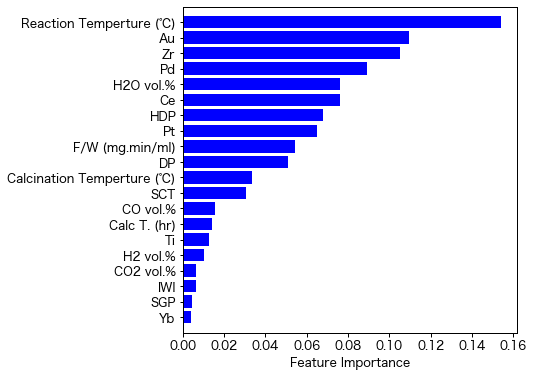

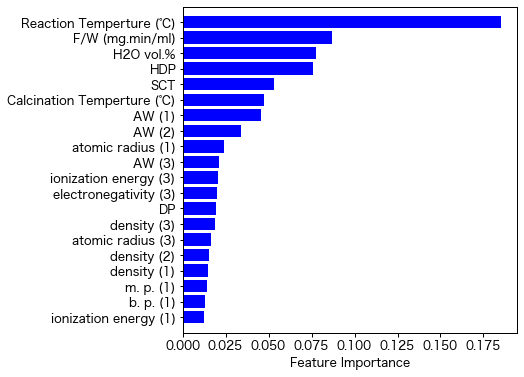

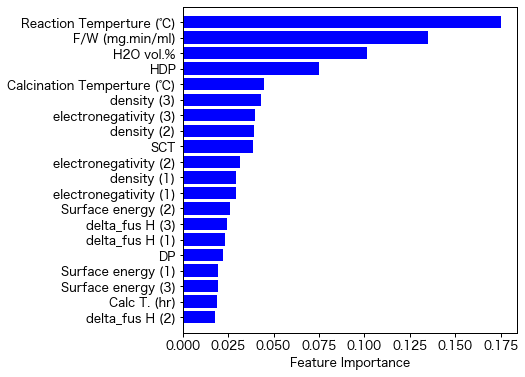

In [19]:
%%time
MODEL_TYPES = ['conv', 'prop2', 'prop3']

os.makedirs('out/ETR', exist_ok=True)
cvf = KFold(n_splits=10, shuffle=True, random_state=1107)
for model_type in MODEL_TYPES:
    print(model_type)
    feat, target = data_load(model_type)
    cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs=1, random_state=1107),
                           param_grid={"n_estimators": [100, 250, 500, 1000, 1500]},
                           n_jobs=4,cv=5)
    error = crossvalid(feat, target, cvmodel, cvf)
    model = opt_ETR(n_estimators=cvmodel.best_params_['n_estimators'], n_jobs=4, random_state=1107)
    model.fit(feat, target)
    plot_importance(model, feat.columns, 20)
    plt.savefig(f'out/ETR/importance_ETR_{model_type}.png', bbox_inches = "tight", dpi = 1200)

conv
RMSE 1.691 (sd: 0.217, min:1.061, max:1.816, det:0.994) ... train
RMSE 10.411 (sd: 5.565, min:3.971, max:25.403, det:0.679) ... test
CPU times: user 16.2 s, sys: 787 ms, total: 17 s
Wall time: 1min 10s


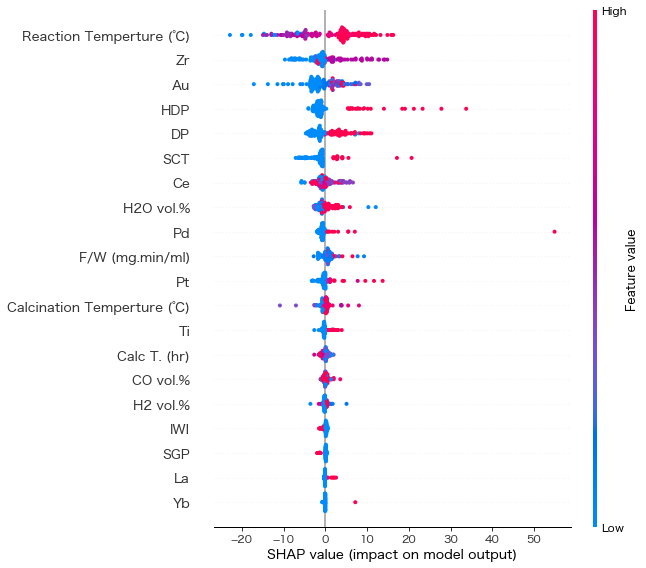

In [20]:
%%time
MODEL_TYPES = ['conv', 'prop2', 'prop3']

print('conv')
cvf = KFold(n_splits=10, shuffle=True, random_state=1107)
feat, target = data_load('conv')
cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs=1, random_state=1107),
                        param_grid={"n_estimators": [100, 250, 500, 1000, 1500]},
                        n_jobs=4,cv=5)
error = crossvalid(feat, target, cvmodel, cvf)
model = opt_ETR(n_estimators=cvmodel.best_params_['n_estimators'], n_jobs=4, random_state=1107)
model.fit(feat, target)
shap_importance(model, feat, target, save='out/ETR/conv_')

prop2
RMSE 1.691 (sd: 0.217, min:1.061, max:1.816, det:0.994) ... train
RMSE 9.638 (sd: 2.822, min:4.582, max:14.757, det:0.708) ... test
CPU times: user 23.3 s, sys: 895 ms, total: 24.2 s
Wall time: 1min 7s


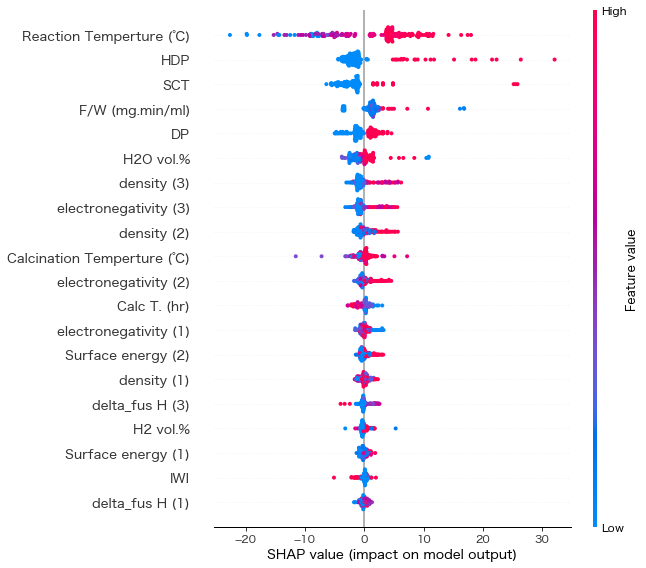

In [21]:
%%time
MODEL_TYPES = ['conv', 'prop2', 'prop3']

print('prop2')
cvf = KFold(n_splits=10, shuffle=True, random_state=1107)
feat, target = data_load('prop3')
cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs=1, random_state=1107),
                        param_grid={"n_estimators": [100, 250, 500, 1000, 1500]},
                        n_jobs=4,cv=5)
error = crossvalid(feat, target, cvmodel, cvf)
model = opt_ETR(n_estimators=cvmodel.best_params_['n_estimators'], n_jobs=4, random_state=1107)
model.fit(feat, target)
shap_importance(model, feat, target, save='out/ETR/prop2_')

prop3
RMSE 1.691 (sd: 0.217, min:1.061, max:1.816, det:0.994) ... train
RMSE 9.638 (sd: 2.822, min:4.582, max:14.757, det:0.708) ... test
CPU times: user 23.4 s, sys: 916 ms, total: 24.3 s
Wall time: 1min 11s


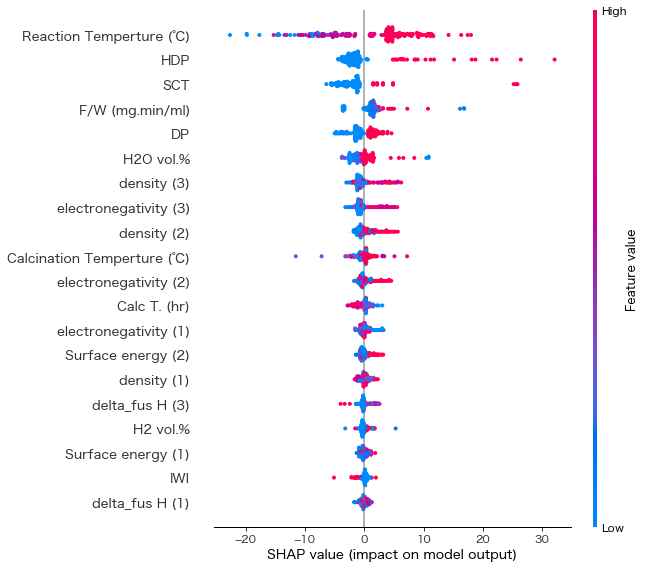

In [22]:
%%time
MODEL_TYPES = ['conv', 'prop2', 'prop3']

print('prop3')
cvf = KFold(n_splits=10, shuffle=True, random_state=1107)
feat, target = data_load('prop3')
cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs=1, random_state=1107),
                        param_grid={"n_estimators": [100, 250, 500, 1000, 1500]},
                        n_jobs=4,cv=5)
error = crossvalid(feat, target, cvmodel, cvf)
model = opt_ETR(n_estimators=cvmodel.best_params_['n_estimators'], n_jobs=4, random_state=1107)
model.fit(feat, target)
shap_importance(model, feat, target, save='out/ETR/prop3_')

In [ ]:
%%time
feat, target = data_load("conv")
rand = []
for i in range(10):
    rand.append(rand_search(10, feat, target, random_state = 1107+7*i))
    
model = opt_ETR(n_estimators=500, n_jobs=-1, random_state=1107)
res_model_bo_et_conv = []
for i in range(10):
    res_model_bo_et_conv.append(bo(10, model, feat, target, random_state=i*10))
    

feat, target = data_load("prop")
model = opt_ETR(n_estimators=500, n_jobs=-1,random_state=1107)
res_model_bo_et = []
for i in range(10):
    res_model_bo_et.append(bo(10,model,feat, target,random_state=i*10))
 

feat, target = data_load("prop2")
model = opt_ETR(n_estimators=500, n_jobs=-1,random_state=1107)
res_model_bo_et_prop2 = []
for i in range(10):
    res_model_bo_et_prop2.append(bo(10,model,feat, target,random_state=i*10))
    

feat, target = data_load("prop3")
model = opt_ETR(n_estimators=500, n_jobs=-1,random_state=1107)
res_model_bo_et_prop2_3 = []
for i in range(10):
    res_model_bo_et_prop2_3.append(bo(10,model,feat, target,random_state=i*10))

    
import sklearn.gaussian_process as gp
kernel = gp.kernels.Matern(nu = 2.5)
model = gp.GaussianProcessRegressor(kernel=kernel,
                                    alpha=1e-2,
                                    n_restarts_optimizer=10,
                                    normalize_y=True,
                                    random_state=1107)
res_model_bo_gp = []
for i in range(10):
    res_model_bo_gp.append(bo(10,model,feat,target,random_state=i*10))
    
rand_pred = np.array(rand).mean(axis=0)
et_mean_pred= np.array([x[2] for x in res_model_bo_et]).mean(axis=0)
et_mean_pred_conv= np.array([x[2] for x in res_model_bo_et_conv]).mean(axis=0)
gp_mean_pred= np.array([x[2] for x in res_model_bo_gp]).mean(axis=0)
et_mean_pred_prop2= np.array([x[2] for x in res_model_bo_et_prop2]).mean(axis=0)
et_mean_pred_prop2_3= np.array([x[2] for x in res_model_bo_et_prop2_3]).mean(axis=0)


plt.figure(figsize=(6,3), dpi=1200)
plt.plot(rand_pred, label='Random Selection')
plt.plot(et_mean_pred, label='Conventional')
#plt.plot(et_mean_pred_conv, label='Proposed(Exploitative), ETR, 9 desc')
plt.plot(et_mean_pred_prop2, label='SWED, ETR (9 desc)')
plt.plot(et_mean_pred_prop2_3, label='SWED, ETR (4 desc)')
#plt.plot(gp_mean_pred, label = "Proposed(Exploitative), GPR, 9 desc")
plt.legend(fontsize =8)
plt.xlabel('Iteration')
plt.ylabel('CO conversion (%)')
plt.savefig('out/speed_test.png', dpi = 600, bbox_inches = 'tight')

In [ ]:
%%time

MODEL_TYPES = ['conv', 'prop', 'prop2', 'prop3']
errors = {}
cvf = KFold(n_splits = 10, random_state = 1107, shuffle = True)
log_param1 = [1e-2, 1e-1, 1.0, 10, 1e2]
log_param2 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
log_param3 = [1.0, 10, 1e2, 1e3, 1e4, 1e5]

for model_type in MODEL_TYPES:
    
    feat, target = data_load(model_type)
    
    print('LASSO', model_type)
    cvmodel = GridSearchCV(Lasso(),
                           param_grid = {'alpha': log_param1},
                           n_jobs = -1)
    errors['LASSO_{}'.format(model_type)] = crossvalid(feat, target, cvmodel, cvf)

    print('Ridge', model_type)
    cvmodel = GridSearchCV(Ridge(),
                           param_grid = {'alpha': log_param1},
                           n_jobs = -1)
    errors['Ridge_{}'.format(model_type)] = crossvalid(feat, target, cvmodel, cvf)

    print('GPR', model_type)
    kernel = gp.kernels.Matern(nu = 2.5)
    cvmodel = GridSearchCV(gp.GaussianProcessRegressor(kernel = kernel,
                                                       normalize_y = True,
                                                       n_restarts_optimizer = 10,
                                                       random_state = 1107),
                           param_grid = {'alpha':log_param2},
                           n_jobs = -1)
    errors['GPR_{}'.format(model_type)] = crossvalid(feat, target, cvmodel, cvf)

    print('SVR', model_type)
    cvmodel = GridSearchCV(SVR(kernel = 'rbf'),
                           param_grid = {'C': log_param3,
                                         'gamma':log_param2,
                                         'epsilon':log_param1}, n_jobs = -1)
    errors['SVR_{}'.format(model_type)] = crossvalid(feat, target, cvmodel, cvf)

    print('RFR', model_type)
    cvmodel = GridSearchCV(RandomForestRegressor(n_jobs=1, random_state=1107),
                           param_grid={"n_estimators": [100, 250, 500, 1000, 1500]}, n_jobs=4,cv=5)
    errors['RFR_{}'.format(model_type)] = crossvalid(feat, target, cvmodel, cvf)

    print('ETR', model_type)
    cvmodel = GridSearchCV(ExtraTreesRegressor(n_jobs=1, random_state=1107),
                                               param_grid={"n_estimators": [100, 250, 500, 1000, 1500]}, n_jobs=4,cv=5)
    errors['ETR_{}'.format(model_type)] = crossvalid(feat, target, cvmodel, cvf)

    print('LGBM', model_type)
    model = LGBMRegressor(n_estimators=500, learning_rate=0.1, max_depth=9, num_leaves=47, max_bin=277, n_jobs=4, random_state=1107)
    errors['LGBM_{}'.format(model_type)] = crossvalid(feat, target, model, cvf)


In [ ]:
methods = ['LASSO', 'Ridge', 'GPR', 'SVR', 'RFR', 'ETR', 'LGBM']
conv = ['{}_conv'.format(m) for m in methods ]
prop = ['{}_prop'.format(m) for m in methods ]
prop2 = ['{}_prop2'.format(m) for m in methods ]
prop3 = ['{}_prop3'.format(m) for m in methods ]

conv_mean = [errors[m]['tes_mean'] for m in conv]
prop_mean = [errors[m]['tes_mean'] for m in prop]
prop2_mean = [errors[m]['tes_mean'] for m in prop2]
prop3_mean = [errors[m]['tes_mean'] for m in prop3]

width =0.2
ind = np.arange(len(methods))
plt.bar(ind,conv_mean, width, color = 'blue', label = 'Conventional method', fontsize=10)
plt.bar(ind+width,prop_mean, width, color = 'green', label = 'Proposed')
plt.bar(ind+2*width, prop2_mean, width, color = 'red', label = 'SWED (9 desc)')
plt.bar(ind+3*width, prop3_mean, width, color = 'orange', label = 'SWED (4 desc)')

for x,y in zip(ind, conv_mean):
    plt.text(x, y+1.0, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=10)

for x,y in zip(ind, prop_mean):
    plt.text(x+width, y+1.0, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=10)

for x,y in zip(ind, prop2_mean):
    plt.text(x+2*width, y+1.0, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=10)  

for x,y in zip(ind, prop3_mean):
    plt.text(x+3*width, y+1.0, '%.2f' % y, ha='center', va= 'bottom', rotation='90', fontsize=10)  
    
plt.xticks(ind + 1.5*width, methods)
plt.ylabel('Test RMSE (%)')
#plt.legend(bbox_to_anchor=(1, 1), loc='upper right', borderaxespad=0, fontsize=10)
plt.legend(bbox_to_anchor=(1, 1), fontsize=10)
plt.ylim(0, 30)
plt.savefig("out/compared_wgs_prediction.png", dpi = 1200, bbox_inches = 'tight')